In [214]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from influxdb import InfluxDBClient
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

In [191]:
df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)


In [192]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
df['day'] = df['ObservationDate'].dt.day
df['month'] = df['ObservationDate'].dt.month
df['year'] = df['ObservationDate'].dt.year
df['hour'] = df['ObservationDate'].dt.hour
df['minute'] = df['ObservationDate'].dt.minute

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171736 entries, 0 to 171735
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   PatientId        171736 non-null  int64         
 1   ObservationDate  171736 non-null  datetime64[ns]
 2   EwsProcedure     171736 non-null  object        
 3   EWS_Total        171736 non-null  int64         
 4   SBP              160949 non-null  float64       
 5   SBP_Score        160949 non-null  float64       
 6   LOC              171736 non-null  object        
 7   LOC_Score        171736 non-null  int64         
 8   SpO2             171734 non-null  float64       
 9   SpO2_Score       171734 non-null  float64       
 10  Add_O2           171734 non-null  object        
 11  Add_O2_Score     171734 non-null  float64       
 12  HR               171736 non-null  int64         
 13  HR_Score         171736 non-null  int64         
 14  RR               171

In [155]:
df.isnull().sum()


PatientId              0
ObservationDate        0
EwsProcedure           0
EWS_Total              0
SBP                10787
SBP_Score          10787
LOC                    0
LOC_Score              0
SpO2                   2
SpO2_Score             2
Add_O2                 2
Add_O2_Score           2
HR                     0
HR_Score               0
RR                     0
RR_Score               0
TEMP                   0
TEMP_Score             0
day                    0
month                  0
year                   0
hour                   0
minute                 0
dtype: int64

In [217]:
def UniqueValues(df):
    # Print the number of unique values of each column, only printing those that have less than 100 unique values

    col = df.columns.tolist()  # Redo this list because columns dropped
    NbrSamples = len(df)

    for c in col:
        s = sorted(set(df[c]))
        #s = set(df[c])
        count = len(s)
        if count == NbrSamples:
            print(f"\n {c} \n\nPossible Index: {count} unique values")
        elif count < 100:
            print(f"\n {c}: {s}")
        else:
            print(f"\n {c}: {count} unique values")

In [218]:
UniqueValues(df)


 PatientId: 10136 unique values

 ObservationDate: 170783 unique values

 EwsProcedure: ['NEWS2']

 EWS_Total: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19]

 SBP: 10964 unique values

 SBP_Score: 10791 unique values

 LOC: ['ALERT', 'NEW_CONFUSION', 'PAIN', 'UNRESPONSIVE', 'VOICE']

 LOC_Score: [0, 3]

 SpO2: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan, nan, 7.0, 9.0, 10.0, 12.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 28.0, 32.0, 36.0, 40.0, 46.0, 50.0, 56.0, 60.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]

 SpO2_Score: [0.0, 1.0, 2.0, 3.0, nan, nan]

 Add_O2: [False, True, nan]

 Add_O2_Score: [0.0, nan, 2.0, nan]

 HR: 180 unique values

 HR_Score: [0, 1, 2, 3]

 RR: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

In [156]:
df['SBP'].fillna(value=df['SBP'].mean(), inplace=True)  # code for NaN => mean value
df['SBP_Score'].fillna(value=df['SBP_Score'].mean(), inplace=True)
df['SpO2_Score'].fillna(value=df['SpO2_Score'].mean(), inplace=True)
df['SpO2'].fillna(value=df['SpO2'].mean(), inplace=True)
df['Add_O2_Score'].fillna(value=df['Add_O2_Score'].mean(), inplace=True)
df['Add_O2'].fillna(value=df['Add_O2_Score'].mean(), inplace=True)

In [157]:
df.isnull().sum().sum() # check the total amount of NaN values in the database

0

In [158]:
#Check the unique values per column
for i in df.columns:
    print(df[i].unique())

[   29    30    31 ... 20530 20531 20532]
['2019-05-01T13:27:50.000000000' '2019-05-01T15:27:44.000000000'
 '2019-05-01T15:54:27.000000000' ... '2020-01-02T09:03:14.000000000'
 '2020-01-02T09:03:20.000000000' '2020-01-02T09:03:56.000000000']
['NEWS2']
[ 0  3  1  2  6  7  5  4  9 10  8 11 12 19 13 14 15]
[143.         120.68866535 117.         135.         125.
 114.         140.         123.         110.         104.
  89.          87.         137.         112.         146.
  94.         127.          92.         201.         191.
  73.         102.         122.         106.         130.
 142.         189.         157.          97.         129.
 109.         121.         152.         132.         147.
 134.         158.         148.         111.         145.
 141.          85.         118.         133.         156.
 149.         124.         113.          93.         131.
 108.         119.         144.         139.         126.
 128.         105.         115.         103.          99.

In [220]:
# Remove records with NULL values:

df = df.dropna(how='any')

In [221]:
# Vectorize 'LOC' column
df['LOC'].replace(to_replace=['ALERT', 'NEW_CONFUSION', 'UNRESPONSIVE', 'VOICE', 'PAIN'], value=[1, 2, 3, 4, 5], inplace=True)

In [223]:
# Vectorize 'Add_O2' column
df['Add_O2'].replace(to_replace=[False, True], value=[0, 1], inplace=True)

In [224]:
#Transforming text and categorical attributes¶

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder ()

for i in df.columns:
    if df[i].dtype == object:
        df[i] = encoder.fit_transform(df[i])
df.head()

,PatientId,ObservationDate,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,...,HR_Score,RR,RR_Score,TEMP,TEMP_Score,day,month,year,hour,minute
0,29,2019-05-01 13:27:50,0,0,143.0,0.0,1,0,96.0,0.0,...,0,18,0,36.6,0,1,5,2019,13,27
2,31,2019-05-01 15:54:27,0,1,117.0,0.0,1,0,95.0,1.0,...,0,14,0,37.3,0,1,5,2019,15,54
4,33,2019-05-01 17:03:16,0,0,135.0,0.0,1,0,97.0,0.0,...,0,14,0,36.1,0,1,5,2019,17,3
8,32,2019-05-01 21:08:05,0,0,125.0,0.0,1,0,97.0,0.0,...,0,14,0,37.1,0,1,5,2019,21,8
10,34,2019-05-01 21:13:21,0,1,117.0,0.0,1,0,95.0,1.0,...,0,13,0,36.6,0,1,5,2019,21,13


In [219]:
# Remove records with faulty temperature readings:

df.drop(df[(df.TEMP < 20.0) | (df.TEMP > 45.0)].index, inplace=True)

In [225]:
#Check the unique values per column
for i in df.columns:
    print(df[i].unique())

[   29    31    33 ... 20530 20531 20532]
['2019-05-01T13:27:50.000000000' '2019-05-01T15:54:27.000000000'
 '2019-05-01T17:03:16.000000000' ... '2020-01-02T09:03:14.000000000'
 '2020-01-02T09:03:20.000000000' '2020-01-02T09:03:56.000000000']
[0]
[ 0  1  2  3  6  7  5  4  9 10  8 12 19 13 11 14 15]
[143. 117. 135. 125. 114. 140. 123. 110. 104.  89.  87. 137. 112. 146.
  94. 127.  92. 201. 191.  73. 102. 122. 106. 130. 142. 189. 157.  97.
 129. 109. 121. 152. 132. 147. 134. 158. 148. 111. 145. 141.  85. 118.
 133. 156. 149. 124. 113.  93. 131. 108. 119. 144. 139. 126. 128. 105.
 115. 103.  99.  88.  98. 138. 136. 167.  91. 164.  90. 100. 116. 150.
 153. 120. 107. 101.  95. 154.  86. 155. 173.  82.  84. 165. 183. 192.
 184.  96. 180. 172. 168. 198.  68. 160. 202. 159. 182. 169. 151.  70.
  58. 161. 175. 163. 177. 181. 185. 166.   0.  60.  72.  64. 179.  66.
 174. 193. 176. 190. 170.  78.  62.  81.  54.  80.  76.  74.  69.  77.
  71. 211.  79. 199. 210. 204. 171. 162.  83.  75. 188. 178. 1

In [212]:
df.duplicated().any()


True

In [162]:
df = df.drop('EwsProcedure',axis=1)


SyntaxError: unexpected EOF while parsing (<ipython-input-211-b138ee785c99>, line 16)

In [163]:
ews_total = df["EWS_Total"].value_counts().sort_values()
ews_total

19        1
15        2
14        3
13       14
12       31
11       84
10      190
9       576
8      1144
7      2312
6      4787
5      8701
4     14289
3     22273
2     31214
1     38752
0     47363
Name: EWS_Total, dtype: int64

In [164]:
Temp_max = df["TEMP"].sort_values()
Temp_max

42378      3.0
77165      3.1
24451      3.2
102610     3.6
43313      6.1
          ... 
49911     40.5
63044     40.8
73655     41.0
1299      42.0
49041     50.0
Name: TEMP, Length: 171736, dtype: float64

In [165]:
df.columns


Index(['PatientId', 'ObservationDate', 'EWS_Total', 'SBP', 'SBP_Score', 'LOC',
       'LOC_Score', 'SpO2', 'SpO2_Score', 'Add_O2', 'Add_O2_Score', 'HR',
       'HR_Score', 'RR', 'RR_Score', 'TEMP', 'TEMP_Score', 'day', 'month',
       'year', 'hour', 'minute'],
      dtype='object')

## Pivot Tables

pivot


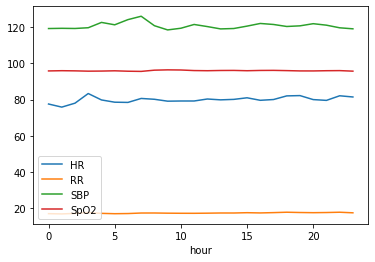

In [167]:
pivot = df.pivot_table(index=['hour'], values=['HR','SBP','SpO2','RR'], aggfunc='mean').plot()

print ('pivot')


pivot


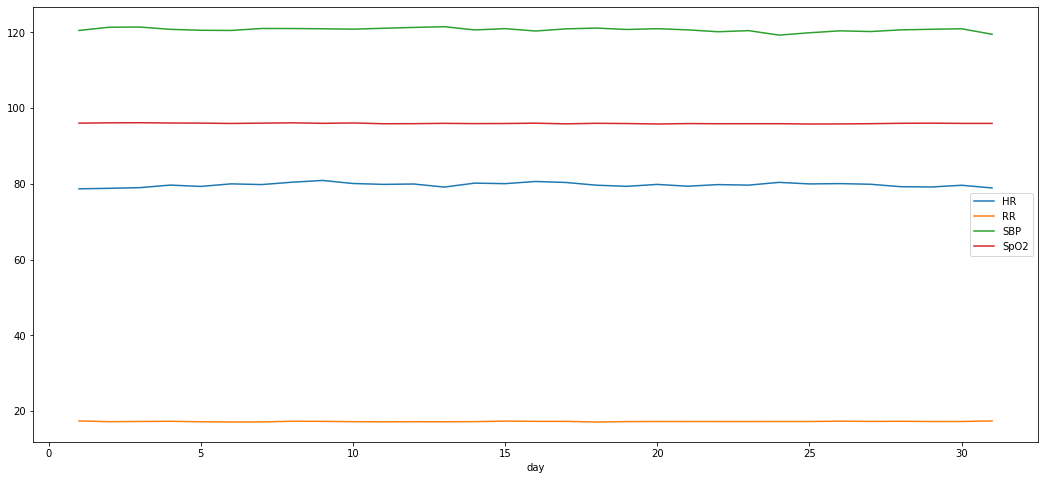

In [168]:
pivot = df.pivot_table(index=['day'], values=['HR','SBP','SpO2','RR'], aggfunc='mean').plot(figsize = (18,8))
pivot
print ('pivot')

pivot


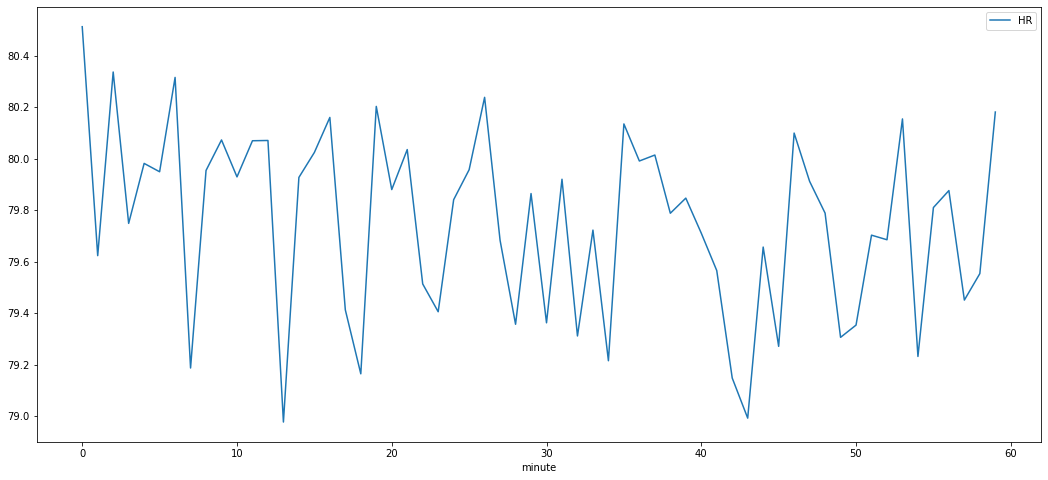

In [169]:



pivot = df.pivot_table(index=['minute'], values=['HR'], aggfunc='mean').plot(figsize = (18,8))

print ('pivot')


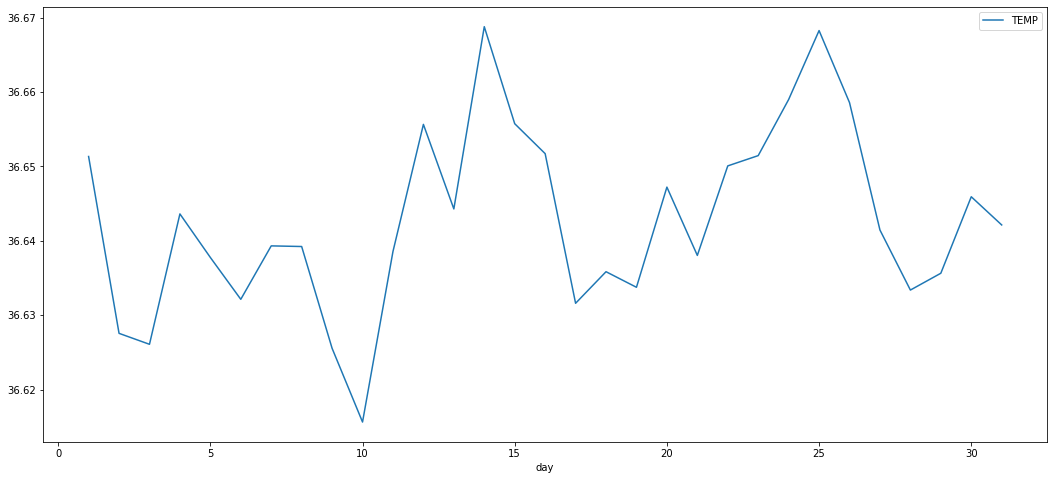

In [183]:
pivot = df.pivot_table(index=['day'], values=['TEMP'], aggfunc='mean').plot(figsize = (18,8))


pivot


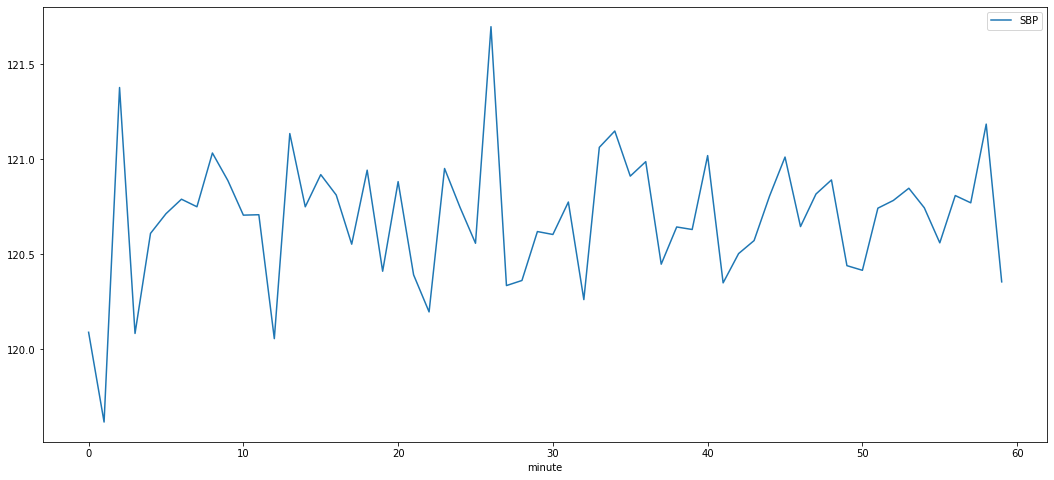

In [170]:
pivot = df.pivot_table(index=['minute'], values=['SBP'], aggfunc='mean').plot(figsize = (18,8))

print ('pivot')


pivot


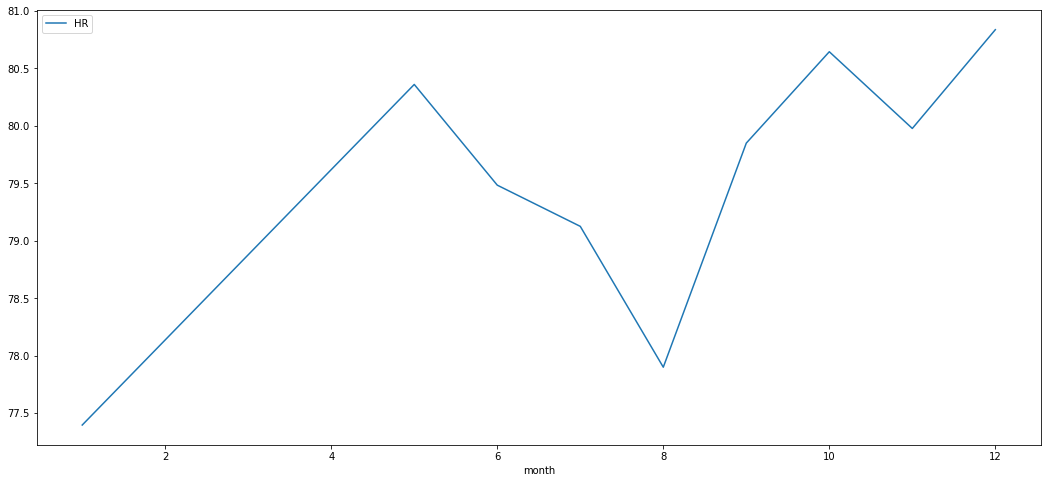

In [173]:
pivot = df.pivot_table(index=['month'], values=['HR'], aggfunc='mean').plot(figsize = (18,8))

print ('pivot')


pivot


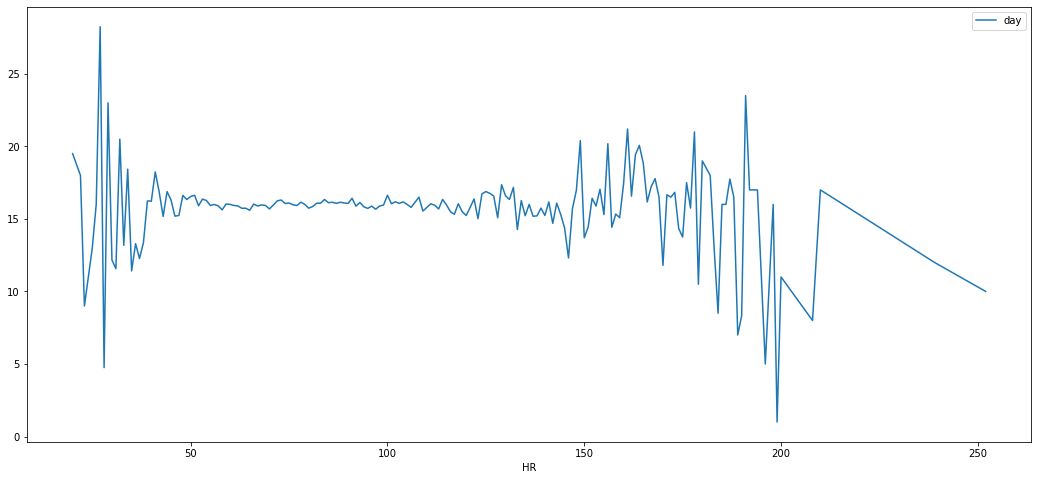

In [181]:
pivot = df.pivot_table(index=['HR'], values=['day'], aggfunc='mean').plot(figsize = (18,8))




In [207]:
start_date = datetime('2019-05-01)
end_date = datetime('2019-05-02')
days= df[start_date:end_date]

SyntaxError: EOL while scanning string literal (<ipython-input-207-4118a3061eeb>, line 1)

NameError: name 'start_date' is not defined

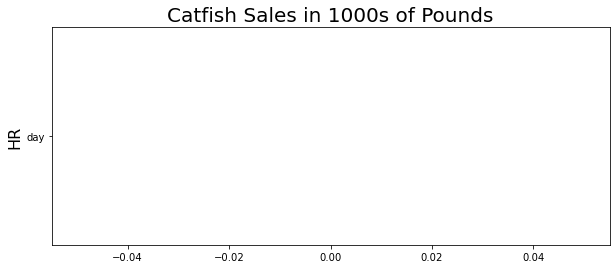

In [201]:
plt.figure(figsize=(10,4))
plt.plot('day')
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('HR', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [186]:
#infer the frequency of the data
df = df.asfreq(pd.infer_freq(df.index))

TypeError: cannot infer freq from a non-convertible index type <class 'pandas.core.indexes.range.RangeIndex'>

In [ ]:
df.columns

In [ ]:
# df = pd.DataFrame(['ObservationDate','EWS_Total','SBP','LOC','SpO2','Add_O2',HR','RR','TEMP'])
# pivot = df.pivot_table(index=['ObservationDate'], values=['HR'], aggfunc='min').plot()

# plt.show()

In [ ]:
df_1 = df[['SBP','HR']]
df_1.index = df["Days"]
df_1
df_1.groupby('PatientId')

In [ ]:
df_1.plot(figsize = (18,8))

In [ ]:
df_2 = df[['SBP','HR']]
df_2.index = df["Hour"]
df_2

In [ ]:
df_2.plot(figsize = (18,8))

## Timeseries data




In [227]:

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [229]:
df = pd.read_csv('ews_prep.csv', parse_dates=['ObservationDate'], index_col='ObservationDate')
print(df.shape)  # (123, 8)
df.tail()

(171736, 23)


,Unnamed: 0,PatientId,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,...,HR_Score,RR,RR_Score,TEMP,TEMP_Score,Days,Month,Year,Hour,Minute
ObservationDate,,,,,,,,,,,,,,,,,,,,,
2020-01-02 08:57:05,171731,20278,0,3,88.0,3.0,0,0,100.0,0.0,...,0,14,0,36.1,0,2,1,2020,8,57
2020-01-02 08:58:46,171732,20480,0,3,83.0,3.0,0,0,92.0,0.0,...,0,18,0,36.8,0,2,1,2020,8,58
2020-01-02 09:03:14,171733,2499,0,0,118.0,0.0,0,0,98.0,0.0,...,0,20,0,36.2,0,2,1,2020,9,3
2020-01-02 09:03:20,171734,20527,0,0,129.0,0.0,0,0,98.0,0.0,...,0,16,0,36.5,0,2,1,2020,9,3
2020-01-02 09:03:56,171735,4853,0,1,133.0,0.0,0,0,98.0,0.0,...,0,15,0,35.9,1,2,1,2020,9,3


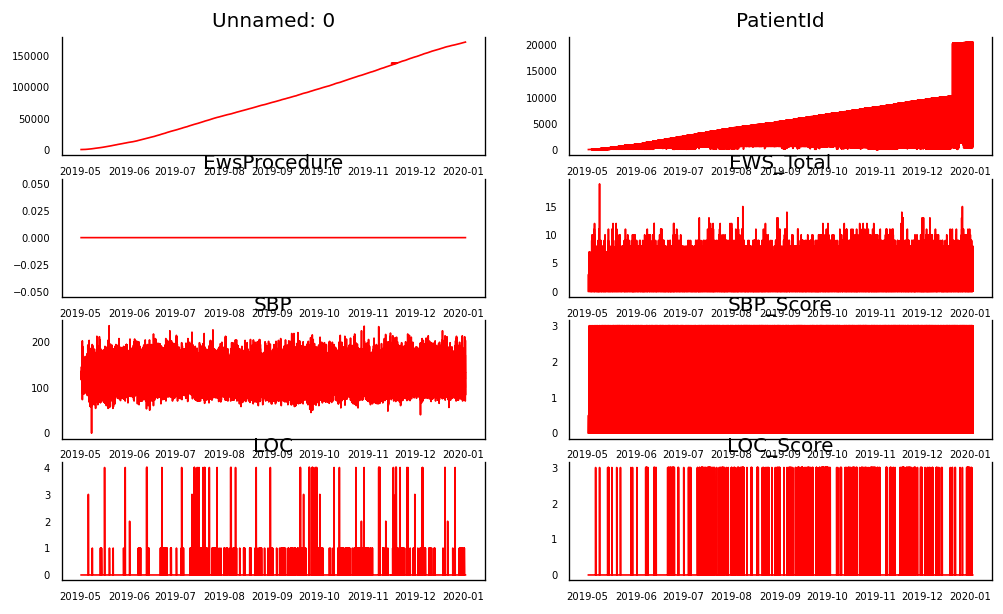

In [230]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [231]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users

Traceback (most recent call last):
  File "C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-231-a23eedf52f07>", line 26, in <module>
    grangers_causation_matrix(df, variables = df.columns)
  File "<ipython-input-231-a23eedf52f07>", line 17, in grangers_causation_matrix
    test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
  File "C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\tsa\stattools.py", line 1381, in grangercausalitytests
    res2djoint = OLS(dta[:, 0], dtajoint).fit()
  File "C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\regression\linear_model.py", line 873, in __init__
    hasconst=hasconst, **kwargs)
  File "C:\Users\maryame\miniconda3\envs\Data-cleaning\lib\site-packages\statsmodels\regression\linear_model.py", line 704, in __init__


TypeError: object of type 'NoneType' has no len()